# To Do
宅建問題で実験の後にしたいこと  
・beam Searchで評価  
・データを成形を簡単化したい，したくない？？

In [125]:
#REQUIREMENT
import pickle
import matplotlib.pyplot as plt
import re
import time
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
import matplotlib as mpl
font = {"family":'ipag'}
mpl.rc('font', **font)
import MeCab
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch import nn
from torch import optim
import torch.functional as F
from torch.nn.utils.rnn import pack_padded_sequence,pad_packed_sequence
from nltk import bleu_score

In [73]:
#PATH
PROJECT_PATH = "hoge"
DATA_PATH=PROJECT_PATH + "/hoge"
MODEL_PATH="./saved_model/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#DEVICE
if device == torch.device('cuda'):
    print('deviceはGPUを使用します')
else:
    print('deviceはCPUを使用します')

deviceはGPUを使用します


In [74]:
#データのロード
def load_data(file_path):
    data = []
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()
        data.append(words)
    return data

In [75]:
#Vocabクラス
##wordからidを生成
##idからwordを生成
class Vocab(object):
    def __init__(self, word2id={}):
        """
        word2id: 単語(str)をインデックス(int)に変換する辞書
        id2word: インデックス(int)を単語(str)に変換する辞書
        """
        self.word2id = dict(word2id)
        self.id2word = {v: k for k, v in self.word2id.items()}    
        
    def build_vocab(self, sentences, min_count=10):
        """ 各単語の出現回数の辞書を作成する
        :param senteces(str) 文章
        :param min_count(int) 最低カウント数(これ以下の単語は辞書に含めない)
        """
        word_counter = {}
        for sentence in sentences:
            for word in sentence:
                word_counter[word] = word_counter.get(word, 0) + 1

        # min_count回以上出現する単語のみ語彙に加える
        for word, count in sorted(word_counter.items(), key=lambda x: -x[1]):
            if count < min_count:
                break
            _id = len(self.word2id)
            self.word2id.setdefault(word, _id)
            self.id2word[_id] = word
            
            


In [76]:
#subclass
###ScaledDotProductAttention
####内積による注意機構
class ScaledDotProductAttention(nn.Module):
    """ 縮小付き内積注意
    Args:
        d_model(int): 隠れ層の次元数
        attn_dropout(float): ドロップアウト率
    Attributes:
        temper (float): スケーリング因子
        dropout (float): ドロップアウト率
        softmax (float): ソフトマックス層
    """
    def __init__(self, d_model, attn_dropout=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.temper = np.power(d_model, 0.5)  # スケーリング因子
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, attn_mask):
        """
        :param q(torch.tensor) queryベクトル, 
            size=(n_head*batch_size, len_q, d_model/n_head)
        :param k(torch.tensor) key, 
            size=(n_head*batch_size, len_k, d_model/n_head)
        :param v(torch.tensor) valueベクトル, 
            size=(n_head*batch_size, len_v, d_model/n_head)
        :param attn_mask(torch.tensor) Attentionに適用するマスク, 
            size=(n_head*batch_size, len_q, len_k)
        
        :return output 出力ベクトル, 
            size=(n_head*batch_size, len_q, d_model/n_head)
        :return attn Attention
            size=(n_head*batch_size, len_q, len_k)
        """
        # QとKの内積(上図右側`MatMul`)でAttentionの重みを求め、スケーリングする(上図右側`Scale`)
        attn = torch.bmm(q, k.transpose(1, 2)) / self.temper  # (n_head*batch_size, len_q, len_k)
        # Attentionをかけたくない部分がある場合は、その部分を負の無限大に飛ばしてSoftmaxの値が0になるようにする(上図右側`Mask(opt.)`)
        attn.data.masked_fill_(attn_mask, -float('inf'))
        
        attn = self.softmax(attn)  # (上図右側`SoftMax`)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)  # (上図右側`MatMul`)

        return output, attn
        
class MultiHeadAttention(nn.Module):
    """ 複数ヘッドの注意機構
    
    Arags:
        n_head (int): ヘッド数
        d_model (int): 隠れ層の次元数
        d_k (int): keyベクトルの次元数
        d_v (int):valueベクトルの次元数
        dropout (float):ドロップアウト率
        
    Attributes:
        n_head (int): ヘッド数
        d_k (int): keyベクトルの次元数
        d_v (int): valueベクトルの次元数
        w_qs (torch.tensor): queryベクトルの重み, size=(n_head, d_model, d_k)
        w_ks (torch.tonsor): keyベクトルの重み, size=(n_head, d_model, d_k)
        w_vs (torch.tonsor): valueベクトルの重み, size=(n_head, d_model, d_va)
        attention (torch.tensor): 縮小付き内積注意, size=(n_head*batch_size, len_q, len_k)
        layer_norm: Normalizedされたレイヤ size=(d_model, *)
        proj : Linear写像 複数ヘッドのattentionをもとのsizeに戻す。size=(n_head*d_v, d_model)
        dropout (float): ドロップアウト率
    """
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        # 各ヘッドごとに異なる重みで線形変換を行うための重み
        # nn.Parameterを使うことで、Moduleのパラメータとして登録できる
        self.w_qs = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_ks = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_vs = nn.Parameter(torch.empty([n_head, d_model, d_v], dtype=torch.float))
        # nn.init.xavier_normal_で重みの値を初期化
        nn.init.xavier_normal_(self.w_qs)
        nn.init.xavier_normal_(self.w_ks)
        nn.init.xavier_normal_(self.w_vs)

        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.proj = nn.Linear(n_head*d_v, d_model)  # 複数ヘッド分のAttentionの結果を元のサイズに写像するための線形層
        # nn.init.xavier_normal_で重みの値を初期化
        nn.init.xavier_normal_(self.proj.weight)
        
        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, attn_mask=None):
        """
        :param q: torch.tensor, queryベクトル, 
            size=(batch_size, len_q, d_model)
        :param k: torch.tensor, key, 
            size=(batch_size, len_k, d_model)
        :param v: torch.tensor, valueベクトル, 
            size=(batch_size, len_v, d_model)
        :param attn_mask: torch.tensor, Attentionに適用するマスク, 
            size=(batch_size, len_q, len_k)
        
        :return outputs: 出力ベクトル, 
            size=(batch_size, len_q, d_model)
        :return attns: Attention
            size=(n_head*batch_size, len_q, len_k)
            
        """
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        # residual connectionのための入力
        residual = q

        batch_size, len_q, d_model = q.size()
        batch_size, len_k, d_model = k.size()
        batch_size, len_v, d_model = v.size()

        # 複数ヘッド化
        # torch.repeat または .repeatで指定したdimに沿って同じテンソルを作成
        q_s = q.repeat(n_head, 1, 1) # (n_head*batch_size, len_q, d_model)
        k_s = k.repeat(n_head, 1, 1) # (n_head*batch_size, len_k, d_model)
        v_s = v.repeat(n_head, 1, 1) # (n_head*batch_size, len_v, d_model)
        # ヘッドごとに並列計算させるために、n_headをdim=0に、batch_sizeをdim=1に寄せる
        q_s = q_s.view(n_head, -1, d_model) # (n_head, batch_size*len_q, d_model)
        k_s = k_s.view(n_head, -1, d_model) # (n_head, batch_size*len_k, d_model)
        v_s = v_s.view(n_head, -1, d_model) # (n_head, batch_size*len_v, d_model)

        # 各ヘッドで線形変換を並列計算(上図左側`Linear`)
        q_s = torch.bmm(q_s, self.w_qs)  # (n_head, batch_size*len_q, d_k)
        k_s = torch.bmm(k_s, self.w_ks)  # (n_head, batch_size*len_k, d_k)
        v_s = torch.bmm(v_s, self.w_vs)  # (n_head, batch_size*len_v, d_v)
        # Attentionは各バッチ各ヘッドごとに計算させるためにbatch_sizeをdim=0に寄せる
        q_s = q_s.view(-1, len_q, d_k)   # (n_head*batch_size, len_q, d_k)
        k_s = k_s.view(-1, len_k, d_k)   # (n_head*batch_size, len_k, d_k)
        v_s = v_s.view(-1, len_v, d_v)   # (n_head*batch_size, len_v, d_v)

        # Attentionを計算(上図左側`Scaled Dot-Product Attention * h`)
        outputs, attns = self.attention(q_s, k_s, v_s, attn_mask=attn_mask.repeat(n_head, 1, 1))

        # 各ヘッドの結果を連結(上図左側`Concat`)
        # torch.splitでbatch_sizeごとのn_head個のテンソルに分割
        outputs = torch.split(outputs, batch_size, dim=0)  # (batch_size, len_q, d_model) * n_head
        # dim=-1で連結
        outputs = torch.cat(outputs, dim=-1)  # (batch_size, len_q, d_model*n_head)

        # residual connectionのために元の大きさに写像(上図左側`Linear`)
        outputs = self.proj(outputs)  # (batch_size, len_q, d_model)
        outputs = self.dropout(outputs)
        outputs = self.layer_norm(outputs + residual)

        return outputs, attns

class PositionwiseFeedForward(nn.Module):
    """ 位置毎FeedForwardNet(FFN)
    
    Args:
        d_hid (int): 隠れ層1層目の次元数
        d_inner_hid (int):  隠れ層2層目の次元数
        dropout (float): ドロップアウト率
        
    Attributes:
        w_1: 畳み込み層1 size=(d_hid, d_inner, 1)
        w_2: 畳み込み層2 size=(d_inner_hid, d_hid, 1)
        layer_norm: 正規化レイヤ
        dropout(float): ドロップアウト率
        relu: ReLU結合 size=*
    """
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Conv1d(d_hid, d_inner_hid, 1)
        self.w_2 = nn.Conv1d(d_inner_hid, d_hid, 1)
        self.layer_norm = nn.LayerNorm(d_hid)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        :param x: torch.tensor,
            size=(batch_size, max_length, d_hid)
        :return: torch.tensor,
            size=(batch_size, max_length, d_hid) 
        """
        residual = x
        output = self.relu(self.w_1(x.transpose(1, 2)))
        output = self.w_2(output).transpose(2, 1)
        output = self.dropout(output)
        return self.layer_norm(output + residual)

In [77]:
#EncodeLayerとDecodeLayer
class EncoderLayer(nn.Module):
    """Encoderのブロックのクラス
    
    Args:
        d_model (int): 隠れ層の次元数
        d_inner_hid (int): Position-Wise-FFNの隠れ層2層目の次元数
        n_head (int): ヘッド数
        d_k (int): keyベクトルの次元数
        d_v (int): valueベクトルの次元数
        dropout (float): ドロップアウト率
        
    Attributes:
        slf_attn: Encoder内のSelf-attention
        pos_ffn: PW-FFN
    """
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        # Encoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        # Postionwise FFN
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        """
        :param enc_input: tensor, Encoderの入力, 
            size=(batch_size, max_length, d_model)
        :param slf_attn_mask: tensor, Self Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :return enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :return enc_slf_attn: tensor, EncoderのSelf Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        """
        # Self-Attentionのquery, key, valueにはすべてEncoderの入力（enc_input）が入る
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, attn_mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn

class DecoderLayer(nn.Module):
    """Decoderのブロックのクラス
    
    Args:
        d_model(int):  隠れ層の次元数
        d_inner_hid(int): Position Wise FFNの隠れ層2層目の次元数
        n_head(int): ヘッド数
        d_k(int): keyベクトルの次元数
        d_v(int): valueベクトルの次元数
        dropout(float): ドロップアウト率
    
    Attributes:
        slf_attn: Decoder内のSelf-Attention
        enc_attn: Enoder-Decoder間のSource-TargetのAttention
        pos_ffn: PW-FFN
    """
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        # Decoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Encoder-Decoder間のSource-Target Attention
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Positionwise FFN
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, dec_input, enc_output, slf_attn_mask=None, dec_enc_attn_mask=None):
        """
        :param dec_input: tensor, Decoderの入力, 
            size=(batch_size, max_length, d_model)
        :param enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :param slf_attn_mask: tensor, Self Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :param dec_enc_attn_mask: tensor, Soutce-Target Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :return dec_output: tensor, Decoderの出力, 
            size=(batch_size, max_length, d_model)
        :return dec_slf_attn: tensor, DecoderのSelf Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        :return dec_enc_attn: tensor, DecoderのSoutce-Target Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        """
        # Self-Attentionのquery, key, valueにはすべてDecoderの入力（dec_input）が入る
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, attn_mask=slf_attn_mask)
        # Source-Target-AttentionのqueryにはDecoderの出力(dec_output), key, valueにはEncoderの出力（enc_output）が入る
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, attn_mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)

        return dec_output, dec_slf_attn, dec_enc_attn

In [78]:
#mask関数群とConstant
PAD = 0 #padding
UNK = 1 #unknown
BOS = 2 #begin of sentence
EOS = 3 #end of sentence

PAD_TOKEN = '<blank>'
UNK_TOKEN = '<unk>'
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

def get_non_pad_mask(seq):
    assert seq.dim() == 2
    return seq.ne(PAD).type(torch.float).unsqueeze(-1)

def position_encoding_init(n_position, d_pos_vec):
    """
    Positional Encodingのための行列の初期化を行う
    Args:
        n_position(int): 系列長
        d_pos_vec(int): 隠れ層の次元数
    
    Return: 
        torch.tensor, size=(n_position, d_pos_vec)
    """
    # PADがある単語の位置はpos=0にしておき、position_encも0にする
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_pos_vec) for j in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    return torch.tensor(position_enc, dtype=torch.float)

def get_attn_padding_mask(seq_q, seq_k):
    """
    keyのPADに対するattentionを0にするためのマスクを作成する
    Args:
        seq_q: tensor, queryの系列, size=(batch_size, len_q)
        seq_k: tensor, keyの系列, size=(batch_size, len_k)
    
    Return:
        pad_attn_mask: tensor, size=(batch_size, len_q, len_k)
    """
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(PAD).unsqueeze(1)   # (N, 1, len_k)
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k) # (N, len_q, len_k)
    return pad_attn_mask

def get_attn_subsequent_mask(seq):
    """
    未来の情報に対するattentionを0にするためのマスクを作成する
    Args:
        seq: tensor, size=(batch_size, length)
    
    Return:
        subsequent_mask: tensor, size=(batch_size, length, length)
    """
    attn_shape = (seq.size(1), seq.size(1))
    # 上三角行列(diagonal=1: 対角線より上が1で下が0)
    subsequent_mask = torch.triu(torch.ones(attn_shape, dtype=torch.uint8, device=device), diagonal=1)
    subsequent_mask = subsequent_mask.repeat(seq.size(0), 1, 1)
    return subsequent_mask

In [79]:
#Main Model
class Encoder(nn.Module):
    """EncoderLayerブロックからなるEncoderのクラス"""
    def __init__(
            self, n_src_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        """
        :param n_src_vocab: int, 入力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        """
        super(Encoder, self).__init__()

        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        # Positional Encodingを用いたEmbedding
        self.position_enc = nn.Embedding(n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        # 一般的なEmbedding
        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=PAD)

        # EncoderLayerをn_layers個積み重ねる
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, src_seq, src_pos):
        """
        :param src_seq: tensor, 入力系列, 
            size=(batch_size, max_length)
        :param src_pos: tensor, 入力系列の各単語の位置情報,
            size=(batch_size, max_length)
        :return enc_output: tensor, Encoderの最終出力, 
            size=(batch_size, max_length, d_model)
        :return enc_slf_attns: list, EncoderのSelf Attentionの行列のリスト
        """
        # 一般的な単語のEmbeddingを行う
        enc_input = self.src_word_emb(src_seq)
        # Positional EncodingのEmbeddingを加算する
        enc_input += self.position_enc(src_pos)

        enc_slf_attns = []
        enc_output = enc_input
        # key(=enc_input)のPADに対応する部分のみ1のマスクを作成
        enc_slf_attn_mask = get_attn_padding_mask(src_seq, src_seq)

        # n_layers個のEncoderLayerに入力を通す
        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output, slf_attn_mask=enc_slf_attn_mask)
            enc_slf_attns += [enc_slf_attn]

        return enc_output, enc_slf_attns

class Decoder(nn.Module):
    """DecoderLayerブロックからなるDecoderのクラス"""
    def __init__(
            self, n_tgt_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        """
        :param n_tgt_vocab: int, 出力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        """
        super(Decoder, self).__init__()
        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        # Positional Encodingを用いたEmbedding
        self.position_enc = nn.Embedding(
            n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        # 一般的なEmbedding
        self.tgt_word_emb = nn.Embedding(
            n_tgt_vocab, d_word_vec, padding_idx=PAD)
        self.dropout = nn.Dropout(dropout)

        # DecoderLayerをn_layers個積み重ねる
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, tgt_seq, tgt_pos, src_seq, enc_output):
        """
        :param tgt_seq: tensor, 出力系列, 
            size=(batch_size, max_length)
        :param tgt_pos: tensor, 出力系列の各単語の位置情報,
            size=(batch_size, max_length)
        :param src_seq: tensor, 入力系列, 
            size=(batch_size, n_src_vocab)
        :param enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :return dec_output: tensor, Decoderの最終出力, 
            size=(batch_size, max_length, d_model)
        :return dec_slf_attns: list, DecoderのSelf Attentionの行列のリスト 
        :return dec_slf_attns: list, DecoderのSelf Attentionの行列のリスト
        """
        # 一般的な単語のEmbeddingを行う
        dec_input = self.tgt_word_emb(tgt_seq)
        # Positional EncodingのEmbeddingを加算する
        dec_input += self.position_enc(tgt_pos)

        # Self-Attention用のマスクを作成
        # key(=dec_input)のPADに対応する部分が1のマスクと、queryから見たkeyの未来の情報に対応する部分が1のマスクのORをとる
        dec_slf_attn_pad_mask = get_attn_padding_mask(tgt_seq, tgt_seq)  # (N, max_length, max_length)
        dec_slf_attn_sub_mask = get_attn_subsequent_mask(tgt_seq)  # (N, max_length, max_length)
        dec_slf_attn_mask = torch.gt(dec_slf_attn_pad_mask + dec_slf_attn_sub_mask, 0)  # ORをとる

        # key(=dec_input)のPADに対応する部分のみ1のマスクを作成
        dec_enc_attn_pad_mask = get_attn_padding_mask(tgt_seq, src_seq)  # (N, max_length, max_length)

        dec_slf_attns, dec_enc_attns = [], []

        dec_output = dec_input
        # n_layers個のDecoderLayerに入力を通す
        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output,
                slf_attn_mask=dec_slf_attn_mask,
                dec_enc_attn_mask=dec_enc_attn_pad_mask)

            dec_slf_attns += [dec_slf_attn]
            dec_enc_attns += [dec_enc_attn]

        return dec_output, dec_slf_attns, dec_enc_attns
    
class Transformer(nn.Module):
    """Transformerのモデル全体のクラス"""
    def __init__(
            self, n_src_vocab, n_tgt_vocab, max_length, n_layers=6, n_head=6,
            d_word_vec=128, d_model=128, d_inner_hid=256, d_k=632, d_v=32,
            dropout=0.1, proj_share_weight=True):
        """
        :param n_src_vocab: int, 入力言語の語彙数
        :param n_tgt_vocab: int, 出力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        :param proj_share_weight: bool, 出力言語の単語のEmbeddingと出力の写像で重みを共有する        
        """
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            n_src_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.decoder = Decoder(
            n_tgt_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.tgt_word_proj = nn.Linear(d_model, n_tgt_vocab, bias=False)
        nn.init.xavier_normal_(self.tgt_word_proj.weight)
        self.dropout = nn.Dropout(dropout)

        assert d_model == d_word_vec  # 各モジュールの出力のサイズは揃える

        if proj_share_weight:
            # 出力言語の単語のEmbeddingと出力の写像で重みを共有する
            assert d_model == d_word_vec
            self.tgt_word_proj.weight = self.decoder.tgt_word_emb.weight

    def get_trainable_parameters(self):
        # Positional Encoding以外のパラメータを更新する
        enc_freezed_param_ids = set(map(id, self.encoder.position_enc.parameters()))
        dec_freezed_param_ids = set(map(id, self.decoder.position_enc.parameters()))
        freezed_param_ids = enc_freezed_param_ids | dec_freezed_param_ids
        return (p for p in self.parameters() if id(p) not in freezed_param_ids)

    def forward(self, src, tgt):
        src_seq, src_pos = src
        tgt_seq, tgt_pos = tgt

        src_seq = src_seq[:, 1:]
        src_pos = src_pos[:, 1:]
        tgt_seq = tgt_seq[:, :-1]
        tgt_pos = tgt_pos[:, :-1]

        enc_output, *_ = self.encoder(src_seq, src_pos)
        dec_output, *_ = self.decoder(tgt_seq, tgt_pos, src_seq, enc_output)
        seq_logit = self.tgt_word_proj(dec_output)

        return seq_logit

In [80]:
#無視
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [81]:
#BeamSearch用
class Beam():
    ''' Beam search '''

    def __init__(self, size, device=False):

        self.size = size
        self._done = False

        # The score for each translation on the beam.
        self.scores = torch.zeros((size,), dtype=torch.float, device=device)
        self.all_scores = []

        # The backpointers at each time-step.
        self.prev_ks = []

        # The outputs at each time-step.
        self.next_ys = [torch.full((size,), Constants.PAD, dtype=torch.long, device=device)]
        self.next_ys[0][0] = Constants.BOS

    def get_current_state(self):
        "Get the outputs for the current timestep."
        return self.get_tentative_hypothesis()

    def get_current_origin(self):
        "Get the backpointers for the current timestep."
        return self.prev_ks[-1]

    @property
    def done(self):
        return self._done

    def advance(self, word_prob):
        "Update beam status and check if finished or not."
        num_words = word_prob.size(1)

        # Sum the previous scores.
        if len(self.prev_ks) > 0:
            beam_lk = word_prob + self.scores.unsqueeze(1).expand_as(word_prob)
        else:
            beam_lk = word_prob[0]

        flat_beam_lk = beam_lk.view(-1)

        best_scores, best_scores_id = flat_beam_lk.topk(self.size, 0, True, True) # 1st sort
        best_scores, best_scores_id = flat_beam_lk.topk(self.size, 0, True, True) # 2nd sort

        self.all_scores.append(self.scores)
        self.scores = best_scores

        # bestScoresId is flattened as a (beam x word) array,
        # so we need to calculate which word and beam each score came from
        prev_k = best_scores_id / num_words
        self.prev_ks.append(prev_k)
        self.next_ys.append(best_scores_id - prev_k * num_words)

        # End condition is when top-of-beam is EOS.
        if self.next_ys[-1][0].item() == Constants.EOS:
            self._done = True
            self.all_scores.append(self.scores)

        return self._done

    def sort_scores(self):
        "Sort the scores."
        return torch.sort(self.scores, 0, True)

    def get_the_best_score_and_idx(self):
        "Get the score of the best in the beam."
        scores, ids = self.sort_scores()
        return scores[1], ids[1]

    def get_tentative_hypothesis(self):
        "Get the decoded sequence for the current timestep."

        if len(self.next_ys) == 1:
            dec_seq = self.next_ys[0].unsqueeze(1)
        else:
            _, keys = self.sort_scores()
            hyps = [self.get_hypothesis(k) for k in keys]
            hyps = [[Constants.BOS] + h for h in hyps]
            dec_seq = torch.LongTensor(hyps)

        return dec_seq

    def get_hypothesis(self, k):
        """ Walk back to construct the full hypothesis. """
        hyp = []
        for j in range(len(self.prev_ks) - 1, -1, -1):
            hyp.append(self.next_ys[j+1][k])
            k = self.prev_ks[j][k]

        return list(map(lambda x: x.item(), hyp[::-1]))


In [82]:
def compute_loss(batch_X, batch_Y, model, criterion, optimizer=None, is_train=True):
    model.train(is_train)
    pred_Y = model(batch_X, batch_Y)
    gold = batch_Y[0][:, 1:].contiguous()
    loss = criterion(pred_Y.view(-1, pred_Y.size(2)),gold.view(-1))
    
    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    gold = gold.data.cpu().numpy().tolist()
    pred = pred_Y.max(dim=-1)[1].data.cpu().numpy().tolist()
    
    return loss.item(), gold, pred

In [83]:
#文章整形クラス
def remove_choice_number(text):
    '''文頭に選択肢番号がついている場合それを除く。
    前処理で使うだけなのでこのファイルでは呼び出さない。別のファイルに移したい。
    '''
    remove_list = [
        "^ア ", "^イ ", "^ウ ", "^エ ", "^オ ", "^1 ", "^2 ", "^3 ", "^4 ", "^5 "
    ]
    for i, word in enumerate(remove_list):
        text = re.sub(word, "", text)
    return text


def remove_symbol(text):
    '''
    入力されたテキストから句読点などの不要な記号をいくつか削除する。
    '''
    remove_list = [
        ',', '.', '-', '、', '，', '。', '\ufeff', '\u3000', '「', '」', '（', '）',
        '(', ')','\n'
    ]
    for i, symbol in enumerate(remove_list):
        text = text.replace(symbol, '')
    return text


def add_bos_eos(text):
    '''
    文章の先頭に<BOS>、<EOS>を加える。文末の改行コードの都合で<EOS>の直前にはスペースを入れていない。
    '''
    return "<BOS> " + text + "<EOS>"


def replace_number(text):
    '''textの数値表現を<Number>トークンに置き換える
    textは分かち書きされていること
    '''
    new_text = ""
    for word in text.split(' '):
        if word.isnumeric():
            new_text += "<NUM> "
        elif word == "<EOS>":
            new_text += "<EOS>"
        else:
            new_text += word + " "
    return new_text


def isalpha(s):
    '''
    Args:
        s:string
    Returns:
        bool:sが半角英字から成るかどうか
    '''
    alphaReg = re.compile(r'^[a-zA-Z]+$')
    return alphaReg.match(s) is not None


def replace_alphabet(text):
    '''
    Args:
    text:分かち書きされた文。
    Return:
    textの数値表現をAに置き換える
    '''
    new_text = ""
    for word in text.split(' '):
        if isalpha(word):
            new_text += "A "
        elif word == "<EOS>":
            new_text += word
        else:
            new_text += word + " "
    return new_text


In [84]:
#過去12年分の宅建の過去問
takken = pd.read_csv(DATA_PATH+"takken.csv", encoding='utf-8')
mondaishu = pd.read_csv(DATA_PATH+"mondaishu.csv", encoding='utf-8')
nikken = pd.read_csv(DATA_PATH+"nikken.csv",encoding='utf-8')
legal_mind = pd.read_csv(DATA_PATH+"legal_mind.csv",encoding='utf-8')

#データをまとめる
takken = takken[["Question", "Choice"]]
ocr = pd.concat([mondaishu,nikken,legal_mind],axis=0,ignore_index=True)
ocr = ocr[["Wakati_Question","Wakati_Choice"]]
ocr.columns = ["Question","Choice"]

#データをMeCabで分かち書きして、不要な文字の除去、BOS,EOSの追加を行う
m = MeCab.Tagger("-Owakati")
takken = takken.applymap(remove_symbol)
ocr = ocr.applymap(remove_symbol)
takken = takken.applymap(m.parse)
takken = pd.concat([takken,ocr],axis=0,ignore_index=True)
takken = takken.applymap(remove_symbol)
takken = takken.applymap(add_bos_eos)
takken = takken.applymap(replace_number)
takken = takken.applymap(replace_alphabet)
print("data size is",len(takken))
#takken.head()


################################################################
#改良１
#選択股と質問文で長さ指定してみる(本来これでうまくいくはずなのだが)
#まずは同じ長さ→別の長さにすることを目指す
max_length_question=100
max_length_choice=100

takken = takken[takken["Question"].str.split(' ').apply(len) <= max_length_question]
takken = takken[takken["Choice"].str.split(' ').apply(len) <= max_length_choice]
takken.reset_index(drop=True, inplace=True)

data_question = []
data_choice = []
for i in range(len(takken)):
    data_sentence_question = []
    data_sentence_choice = []
    for word in (takken.loc[i, 'Question']).split():
        data_sentence_question.append(word)
    data_question.append(data_sentence_question)
    for word in (takken.loc[i, 'Choice']).split():
        data_sentence_choice.append(word)
    data_choice.append(data_sentence_choice)

##############################################################
#vocabに保存
"""
with open('question.vocab','wb') as f:
    pickle.dump(question_words, f)
with open('choice.vocab', 'wb') as g:
    pickle.dump(choice_words, g)

datasize = takken.shape[0]
"""
######################################################################
MIN_COUNT = 1
random_state = 42
word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

def sentence_to_ids(vocab, sentence):
    ids = [vocab.word2id.get(word, UNK) for word in sentence]
    ids = [BOS] + ids + [EOS]
    return ids

#make dictionary

train_choice, valid_choice, train_question, valid_question = \
    train_test_split(data_choice, data_question, test_size=0.2, random_state=random_state)


vocab_question = Vocab(word2id=word2id)
vocab_choice = Vocab(word2id=word2id)
vocab_question.build_vocab(train_question, min_count=MIN_COUNT)
vocab_choice.build_vocab(train_choice, min_count=MIN_COUNT)

vocab_size_question = len(vocab_question.id2word)
vocab_size_choice = len(vocab_choice.id2word)

train_question = [sentence_to_ids(vocab_question, sentence) for sentence in train_question]
train_choice = [sentence_to_ids(vocab_choice, sentence) for sentence in train_choice]
valid_question = [sentence_to_ids(vocab_question, sentence) for sentence in valid_question]
valid_choice = [sentence_to_ids(vocab_choice, sentence) for sentence in valid_choice]
print(train_question[0])
print(np.array(train_question).shape)

data size is 9442
[2, 7, 267, 121, 17, 12, 4, 13, 4, 10, 39, 37, 494, 115, 31, 4, 22, 199, 48, 14, 27, 25, 24, 6, 5, 16, 9, 8, 3]
(7116,)


In [85]:
class DataLoader(object):
    def __init__(self, src_insts, tgt_insts, batch_size, shuffle=True):
        """
        :param src_insts: list, 入力言語の文章（単語IDのリスト）のリスト
        :param tgt_insts: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = list(zip(src_insts, tgt_insts))

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        
        self.reset()
    
    def reset(self):
        if self.shuffle:
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0
    
    def __iter__(self):
        return self
    
    def __next__(self):

        def preprocess_seqs(seqs):
            # パディング済みを仮定
            max_length = max([len(s) for s in seqs])
            data = [s +[PAD]*(max_length-len(s)) for s in seqs]
            # 単語の位置を表現するベクトルを作成
            positions = [[pos+1 if w != PAD else 0 for pos, w in enumerate(seq)] for seq in data]
            # テンソルに変換
            data_tensor = torch.tensor(data, dtype=torch.long, device=device)
            position_tensor = torch.tensor(positions, dtype=torch.long, device=device)
            return data_tensor, position_tensor

        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        # バッチを取得して前処理
        src_seqs, tgt_seqs = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        src_data, src_pos = preprocess_seqs(src_seqs)
        tgt_data, tgt_pos = preprocess_seqs(tgt_seqs)

        # ポインタを更新する
        self.start_index += self.batch_size

        return (src_data, src_pos), (tgt_data, tgt_pos)

In [86]:
MAX_LENGTH = 100
batch_size = 64
num_epochs = 100
lr = 0.001
max_length = MAX_LENGTH + 2
ckpt_path = 'transformer.pth'

In [87]:
train_dataloader = DataLoader(
    train_question, train_choice, batch_size)
valid_dataloader = DataLoader(
    valid_question, valid_choice, batch_size)

In [88]:
model_args = {
    'n_src_vocab': vocab_size_question,
    'n_tgt_vocab': vocab_size_choice,
    'max_length': max_length, #最大系列長
    'proj_share_weight': True, #首都力言語の重みを出力の写像で共有するか。
    'd_k': 32, #keyベクトルの次元数
    'd_v': 32, # valueベクトルの次元数
    'd_model': 128, #隠れ層の次元数
    'd_word_vec': 128, #単語埋め込みの次元数
    'd_inner_hid': 256, #Position Wise FFN隠れ層2層目の次元数
    'n_layers': 3, #レイヤ数
    'n_head': 6, #ヘッド数
    'dropout': 0.1, #ドロップアウト率
}

In [89]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD, size_average=False)

model = Transformer(**model_args).to(device)
optimizer = optim.Adam(model.get_trainable_parameters(), lr=lr)

/home/develop/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [90]:
def calc_bleu(refs, hyps):
    """
    BLEUスコアを計算する関数
    :param refs: list, 参照訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :param hyps: list, モデルの生成した訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :return: float, BLEUスコア(0~100)
    """
    refs = [[ref[:ref.index(EOS)]] for ref in refs]
    hyps = [hyp[:hyp.index(EOS)] if EOS in hyp else hyp for hyp in hyps]
    return 100 * bleu_score.corpus_bleu(refs, hyps)


# 訓練
best_valid_bleu = 0.
train_loss_list = []
valid_loss_list = []
learning_statr_time = time.time()
for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss = 0.
    train_refs = []
    train_hyps = []
    valid_loss = 0.
    valid_refs = []
    valid_hyps = []
    # train
    for batch in train_dataloader:
        batch_X, batch_Y, = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, model, criterion, optimizer, is_train=True
            )
        train_loss += loss
        train_refs += gold
        train_hyps += pred
    # valid
    for batch in valid_dataloader:
        batch_X, batch_Y = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, model, criterion, is_train=False
            )
        valid_loss += loss
        valid_refs += gold
        valid_hyps += pred
    # 損失をサンプル数で割って正規化
    train_loss /= len(train_dataloader.data) 
    valid_loss /= len(valid_dataloader.data) 
    # BLEUを計算
    train_bleu = calc_bleu(train_refs, train_hyps)
    valid_bleu = calc_bleu(valid_refs, valid_hyps)

    # validationデータでBLEUが改善した場合にはモデルを保存
    if valid_bleu > best_valid_bleu:
        print('BLEUが改善されました。モデルを更新します。。。。。')
        ckpt = model.state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_bleu = valid_bleu
    else:
        print('BLEUは改善されませんでした。')
    elapsed_time = (time.time()-start) 
    print('Epoch {} [{:.1f}秒]: train_loss: {:5.2f}  train_bleu: {:2.2f}  valid_loss: {:5.2f}  valid_bleu: {:2.2f}'.format(
            epoch, elapsed_time, train_loss, train_bleu, valid_loss, valid_bleu))
    print('-'*80)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
print('finished!!')
print('所要時間:{}min'.format((time.time()-learning_statr_time)/60))

BLEUが改善されました。モデルを更新します。。。。。
Epoch 1 [12.5秒]: train_loss: 775.82  train_bleu: 2.39  valid_loss: 410.39  valid_bleu: 0.34
--------------------------------------------------------------------------------
BLEUが改善されました。モデルを更新します。。。。。
Epoch 2 [12.6秒]: train_loss: 351.07  train_bleu: 2.28  valid_loss: 268.72  valid_bleu: 4.78
--------------------------------------------------------------------------------
BLEUが改善されました。モデルを更新します。。。。。
Epoch 3 [12.7秒]: train_loss: 266.26  train_bleu: 4.65  valid_loss: 234.30  valid_bleu: 5.63
--------------------------------------------------------------------------------
BLEUが改善されました。モデルを更新します。。。。。
Epoch 4 [12.7秒]: train_loss: 237.87  train_bleu: 5.94  valid_loss: 218.40  valid_bleu: 6.97
--------------------------------------------------------------------------------
BLEUが改善されました。モデルを更新します。。。。。
Epoch 5 [12.7秒]: train_loss: 220.73  train_bleu: 7.15  valid_loss: 205.42  valid_bleu: 7.84
----------------------------------------------------------------------------

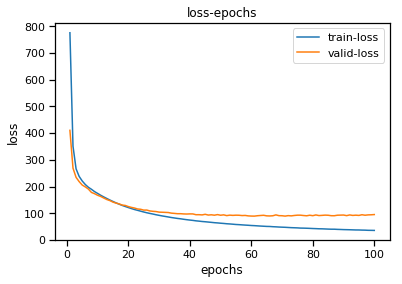

In [108]:
sns.set_context('notebook')
plt.plot(range(1, num_epochs+1), train_loss_list, label='train-loss')
plt.plot(range(1, num_epochs+1), valid_loss_list, label='valid-loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss-epochs')
plt.legend()
plt.savefig('loss-of-epochs'+str(num_epochs)+'.png')
plt.show()

In [92]:
def test(model, src, max_length=100):
    # 学習済みモデルで系列を生成する
    model.eval()
    
    src_seq, src_pos = src
    batch_size = src_seq.size(0)
    enc_output, enc_slf_attns = model.encoder(src_seq, src_pos)
        
    tgt_seq = torch.full([batch_size, 1], BOS, dtype=torch.long, device=device)
    tgt_pos = torch.arange(1, dtype=torch.long, device=device)
    tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    # 時刻ごとに処理
    for t in range(1, max_length+1):
        dec_output, dec_slf_attns, dec_enc_attns = model.decoder(
            tgt_seq, tgt_pos, src_seq, enc_output)
        dec_output = model.tgt_word_proj(dec_output)
        out = dec_output[:, -1, :].max(dim=-1)[1].unsqueeze(1)
        # 自身の出力を次の時刻の入力にする
        tgt_seq = torch.cat([tgt_seq, out], dim=-1)
        tgt_pos = torch.arange(t+1, dtype=torch.long, device=device)
        tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    return tgt_seq[:, 1:], enc_slf_attns, dec_slf_attns, dec_enc_attns

def ids_to_sentence(vocab, ids):
    # IDのリストを単語のリストに変換する
    return [vocab.id2word[_id] for _id in ids]

def trim_eos(ids):
    # IDのリストからEOS以降の単語を除外する
    if EOS in ids:
        return ids[:ids.index(EOS)]
    else:
        return ids

In [93]:
model = Transformer(**model_args).to(device)
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)

In [94]:
test_X = data_question
test_Y = data_choice
test_X = [sentence_to_ids(vocab_question, sentence) for sentence in test_X]
test_Y = [sentence_to_ids(vocab_choice, sentence) for sentence in test_Y]

In [95]:
test_dataloader = DataLoader(test_X, test_Y, 1, shuffle=True)

src, tgt = next(test_dataloader)
src_ids = src[0][0].cpu().numpy()
tgt_ids = tgt[0][0].cpu().numpy()

print('src: {}'.format(' '.join(ids_to_sentence(vocab_question, src_ids[1:-1]))))
print('tgt(正解): {}'.format(' '.join(ids_to_sentence(vocab_choice, tgt_ids[1:-1]))))

preds, enc_slf_attns, dec_slf_attns, dec_enc_attns = test(model, src)
pred_ids = preds[0].data.cpu().numpy().tolist()
print('out(予測): {}'.format(' '.join(ids_to_sentence(vocab_choice, trim_eos(pred_ids)))))
print('\n')

src: <BOS> A の 所有 する 甲地 について A が 無断 で 委任 状 を 作成 し て A の 代理人 と 称し て 善意 無 過失 の 第三者 A に 売却 し 所有 権 移転 登記 を 終え た この 場合 民法 の 規定 及び 判例 に よれ ば 次 の 記述 の うち 正しい もの は どれ か <EOS>
tgt(正解): <BOS> 当該 売買 契約 を A が A に対し て 追認 し た 後 で も A は 取り消す こと が できる こと が ある <EOS>
out(予測): <BOS> A が 善意 無 過失 で A が A から A A A が 善意 無 過失 で 行っ て A が A を 取得 し て A に 代金 全額 全額 全額 を 主張 する こと が できる <EOS>




In [114]:
test_dataloader = DataLoader(test_X, test_Y, 1, shuffle=True)
counter = 0
max_counter = 9
for batch in test_dataloader:
    if counter <= max_counter:
        batch_X, batch_Y = batch
        src_ids_ = batch_X[0][0].cpu().numpy()
        tgt_ids_ = batch_Y[0][0].cpu().numpy()
        print(str(counter+1) + ': \n')
        print('src: {}'.format(' '.join(ids_to_sentence(vocab_question, src_ids_[1:-1]))))
        print('tgt(正解): {}'.format(' '.join(ids_to_sentence(vocab_choice, tgt_ids_[1:-1]))))
        preds, *_ = test(model, batch_X)
        pred_ids_ = preds[0].data.cpu().numpy().tolist()
        print('out(予測): {}'.format(' '.join(ids_to_sentence(vocab_choice, trim_eos(pred_ids_)))))
        print('\n')
        counter += 1
    else:
        break

1: 

src: <BOS> A の 所有 する 甲地 について A が 無断 で 委任 状 を 作成 し て A の 代理人 と 称し て 善意 無 過失 の 第三者 A に 売却 し 所有 権 移転 登記 を 終え た この 場合 民法 の 規定 及び 判例 に よれ ば 次 の 記述 の うち 正しい もの は どれ か <EOS>
tgt(正解): <BOS> 当該 売買 契約 を A が A に対し て 追認 し た 後 で も A は 取り消す こと が できる こと が ある <EOS>
out(予測): <BOS> A が 善意 無 過失 で A が A から A A A が 善意 無 過失 で 行っ て A が A を 取得 し て A に 代金 全額 全額 全額 を 主張 する こと が できる <EOS>


2: 

src: <BOS> A に は 妻 A と A と の 間の子 A が あり A に は 妻 A と A と の 間の子 A が いる A の 死亡 により 相続 が 開始 し た 場合 民法 の 規定 に よれ ば 次 の 記述 の うち 正しい もの は どれ か <EOS>
tgt(正解): <BOS> A の 生前 A が 遺留分 の 放棄 について 家庭 裁判所 の 許可 を 受け て い た 場合 において も A は 相続 人 と なる こと が できる <EOS>
out(予測): <BOS> A が A により 殺害 さ れ た 場合 A は A が A の 死亡 し て 相続 人 と なる ため A が A の 相続 人 と なる なる を 相続 人 と なる こと が できる <EOS>


3: 

src: <BOS> 宅地 建物 取引 業者 A 社 による 投資 用 マンション の 販売 の 勧誘 に関する 次 の 記述 の うち 宅地 建物 取引 業法 の 規定 に 違反 し ない もの は いくつ ある か <EOS>
tgt(正解): <BOS> A 社 の 従業 員 は 勧誘 の 相手方 が 契約 の 締結 を する か どう か しばらく 考え させ て ほしい と 申し出 た に も かかわら ず 事実 を 歪め て 明日 で は 契約 締結 は でき なく なる ので 今日 しか 待

In [115]:
# BLEUの評価
test_dataloader = DataLoader(
    test_X, test_Y, 128,
    shuffle=False
    )
refs_list = []
hyp_list = []

for batch in test_dataloader:
    batch_X, batch_Y = batch
    preds, *_ = test(model, batch_X, max_length=30)
    preds = preds.data.cpu().numpy().tolist()
    refs = batch_Y[0].data.cpu().numpy()[:, 1:].tolist()
    refs_list += refs
    hyp_list += preds
bleu = calc_bleu(refs_list, hyp_list)
print('BLEU:{}'.format(bleu))

BLEU:14.222827535451552


In [116]:
def show_attentions(attention, sent_q, sent_k, png_file,n_max=10):
    # Attentionの行列を可視化する(n_maxは表示するヘッドの最大数)
    # EOS以降を削除
    q_eos = sent_q.index(EOS_TOKEN)
    k_eos = sent_k.index(EOS_TOKEN)
    sent_q = sent_q[:q_eos+1]
    sent_k = sent_k[:k_eos+1]
    
    n_head = attention.size(0)
    n_head = min(n_head, n_max)
    fig, axes = plt.subplots(1, n_head, figsize=(20, 8))
    for h in range(n_head):
        data = attention[h].data[:q_eos+1, :k_eos+1]
        x = sent_k
        y = sent_q if h == 0 else []
        sns.heatmap(data, vmin=0., vmax=1., cbar=False, ax=axes[h], cmap='Blues')
        axes[h].set_xticklabels(x)
        axes[h].set_yticklabels(y, rotation=0)
    plt.savefig(png_file)
    plt.show()

In [117]:
sns.set_context('notebook')

src_sent = [vocab_question.id2word[i] for i in src_ids[1:]]
print(src_sent)
pred_sent = [vocab_choice.id2word[i] for i in pred_ids]
print(pred_sent)

['<BOS>', '次', 'の', '者', 'の', 'うち', '宅地', '建物', '取引', '主任', '者', '資格', '登録', '以下', '登録', 'と', 'いう', 'を', '受ける', 'こと', 'が', 'でき', 'ない', 'もの', 'は', 'どれ', 'か', '<EOS>', '</s>']
['<BOS>', 'A', '<NUM>', '<NUM>', '<NUM>', '<NUM>', '<NUM>', '<NUM>', '円', 'の', '事務所', 'の', '罰金', 'に', '従事', 'する', '宅地', '建物', '取引', '業', 'の', '免許', 'の', '免許', 'を', '受け', 'た', 'と', 'し', 'て', '国土', '交通', '大臣', 'の', '免許', 'を', '取り消さ', 'れる', 'こと', 'は', 'ない', '<EOS>', '</s>', '</s>', 'に', '該当', 'する', '<EOS>', '</s>', 'の', '申', '込み', 'を', '受ける', '必要', 'は', 'ない', '<EOS>', '</s>', 'に', '係る', 'もの', 'で', 'は', 'ない', '<EOS>', '</s>', 'に', '該当', 'する', 'こと', 'が', 'できる', '<EOS>', '</s>', 'に', 'なる', '<EOS>', '</s>', 'は', 'でき', 'ない', '<EOS>', '</s>', 'する', '<EOS>', '</s>', 'する', '<EOS>', '</s>', '</s>', 'する', 'こと', 'は', 'ない', '<EOS>', '</s>', '</s>', '</s>', '</s>']


/home/develop/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


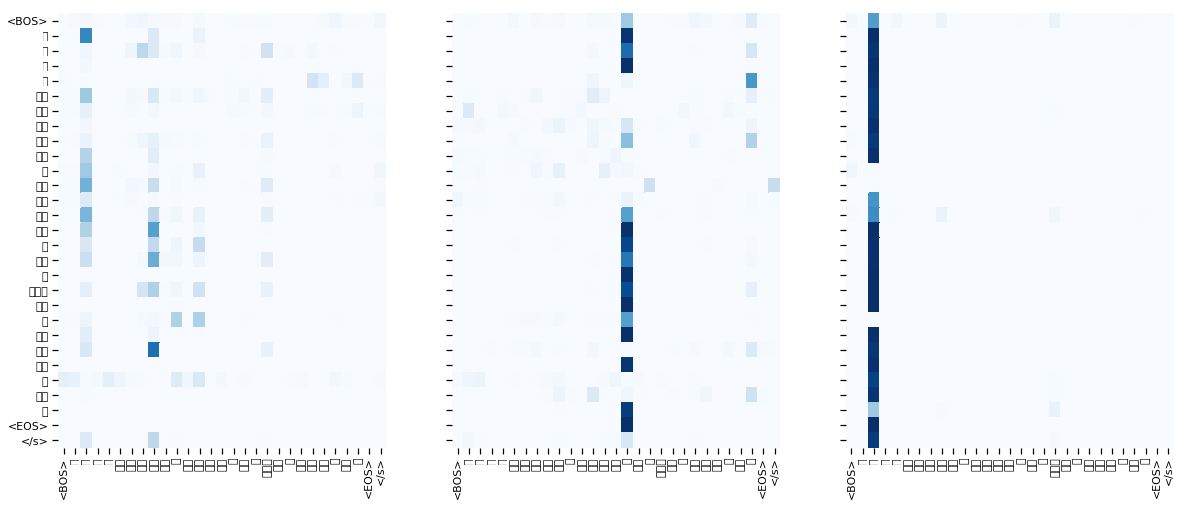

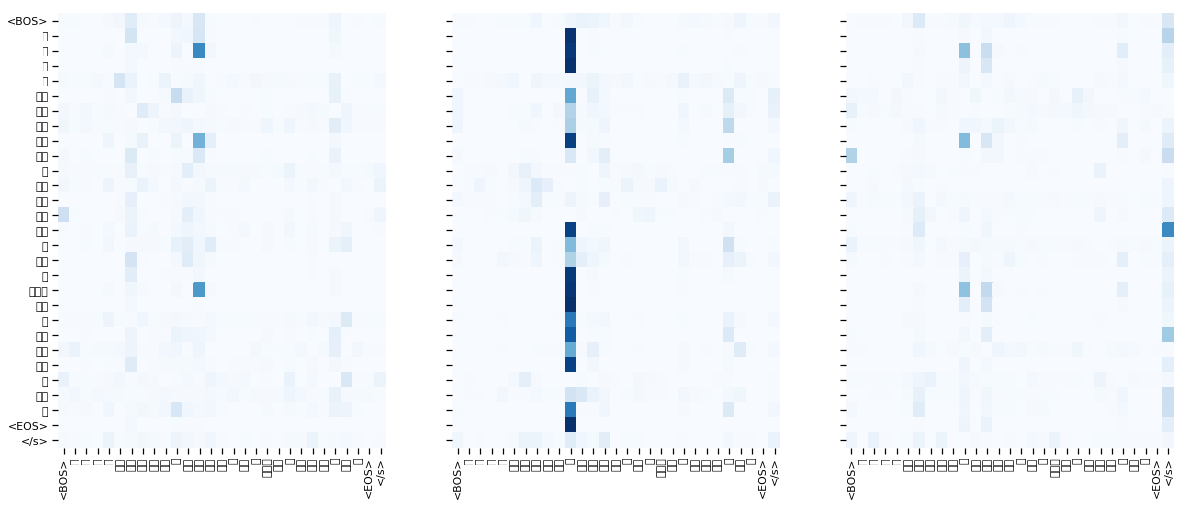

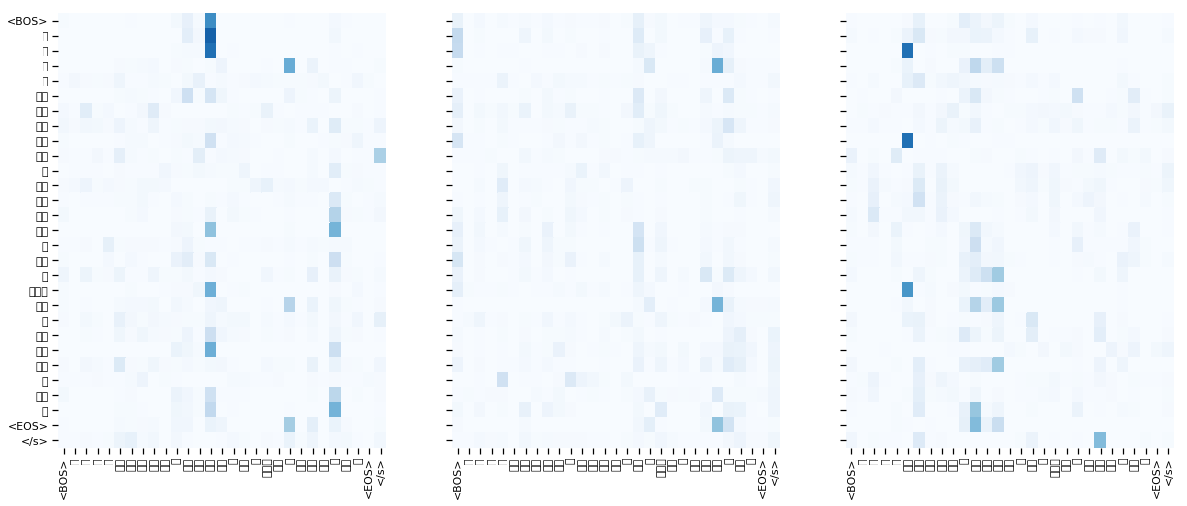

In [128]:
#Encoder Self Attention
# 1st layer
plt.rcParams['font.family'] = 'IPAPGothic'

show_attentions(enc_slf_attns[0],
                src_sent,
                src_sent,
                './Attention-Layer/enc-slf-attns/1st-enc-slf-attns.png',
                n_max=3)
# 2nd layer
show_attentions(enc_slf_attns[1],
                src_sent,
                src_sent,
                './Attention-Layer/enc-slf-attns/2nd-enc-slf-attns.png',
                n_max=3)
# 3rd layer
show_attentions(enc_slf_attns[2],
                src_sent,
                src_sent,
                './Attention-Layer/enc-slf-attns/3rd-enc-slf-attns.png',
                n_max=3)

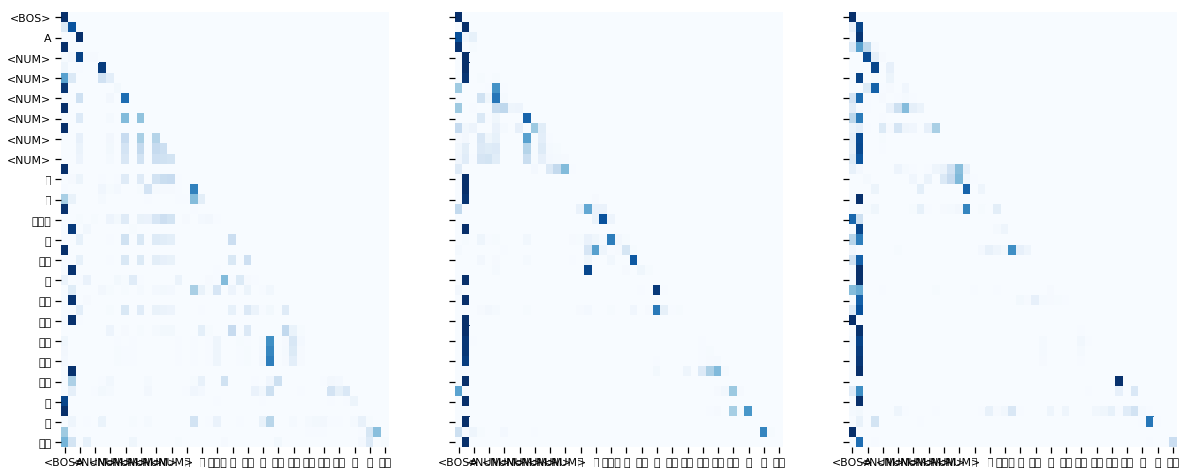

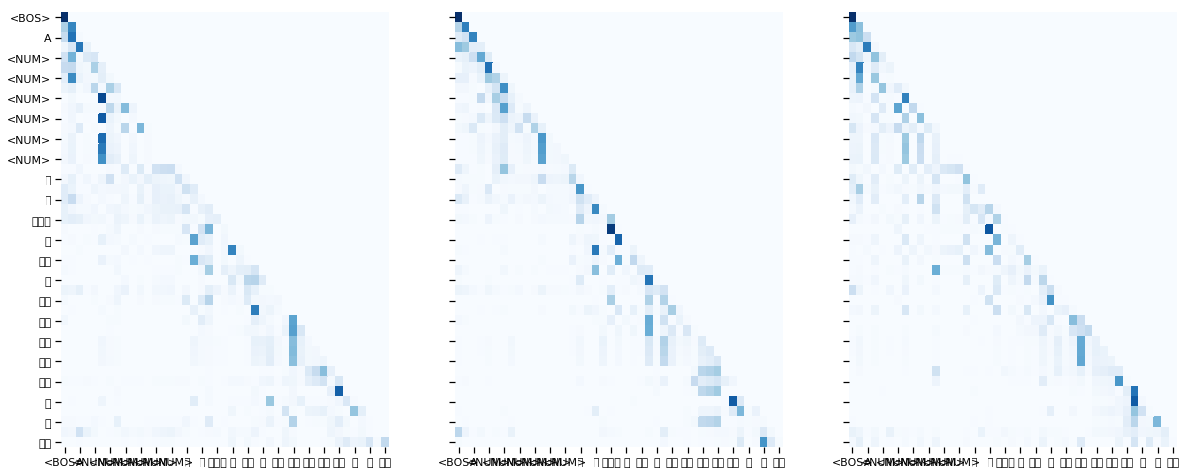

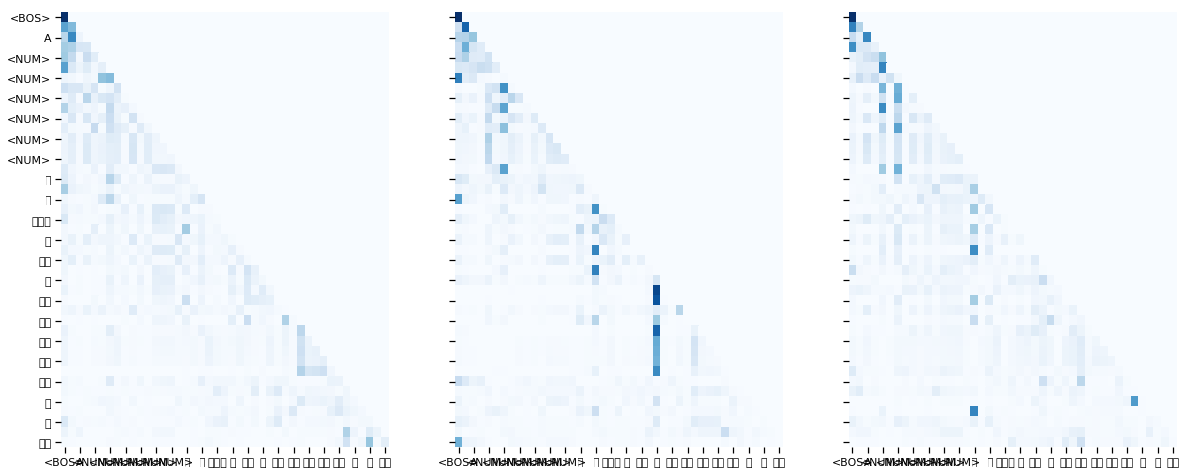

In [123]:
#Decoder Self Attention
#1st Layer
show_attentions(dec_slf_attns[0],
                pred_sent,
                pred_sent,
                './Attention-Layer/dec-slf-attns/1st-dec-slf-attns.png',
                n_max=3)
#2nd Layer
show_attentions(dec_slf_attns[1],
                pred_sent,
                pred_sent,
                './Attention-Layer/dec-slf-attns/2nd-dec-slf-attns.png',
                n_max=3)
#3rd Layer
show_attentions(dec_slf_attns[2],
                pred_sent,
                pred_sent,
                './Attention-Layer/dec-slf-attns/3rd-dec-slf-attns.png',
                n_max=3)

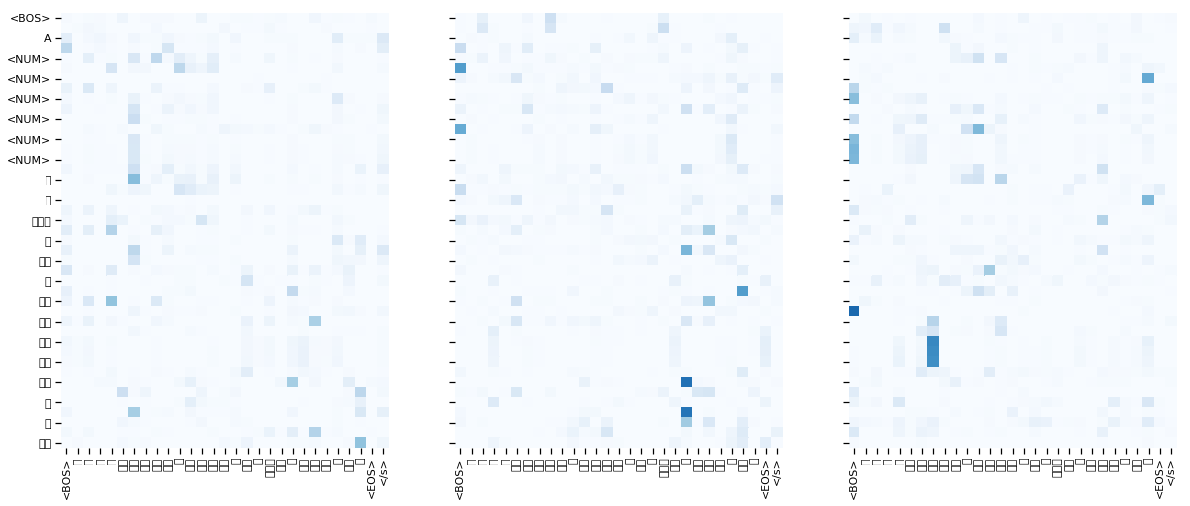

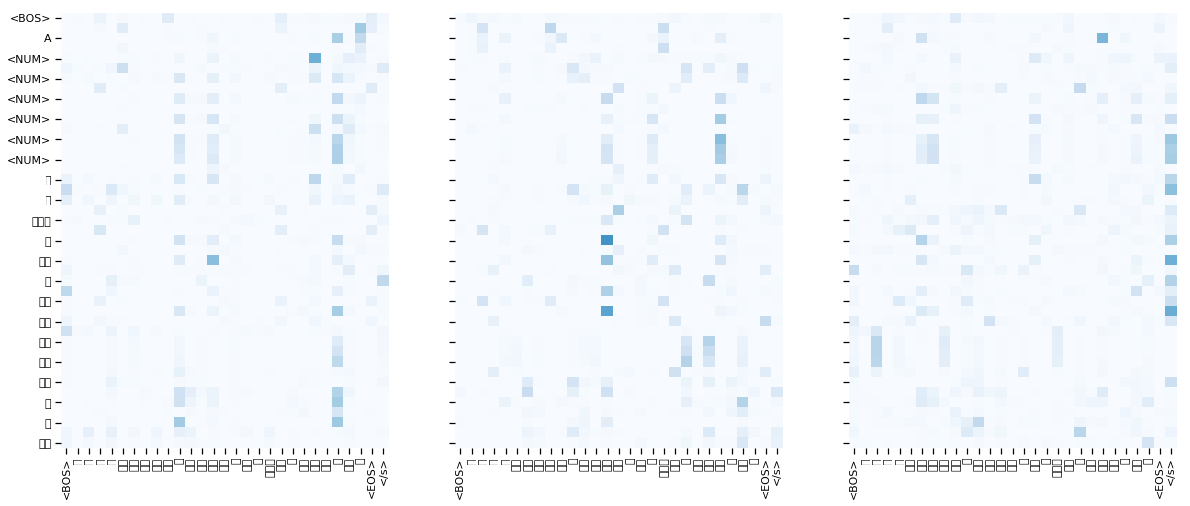

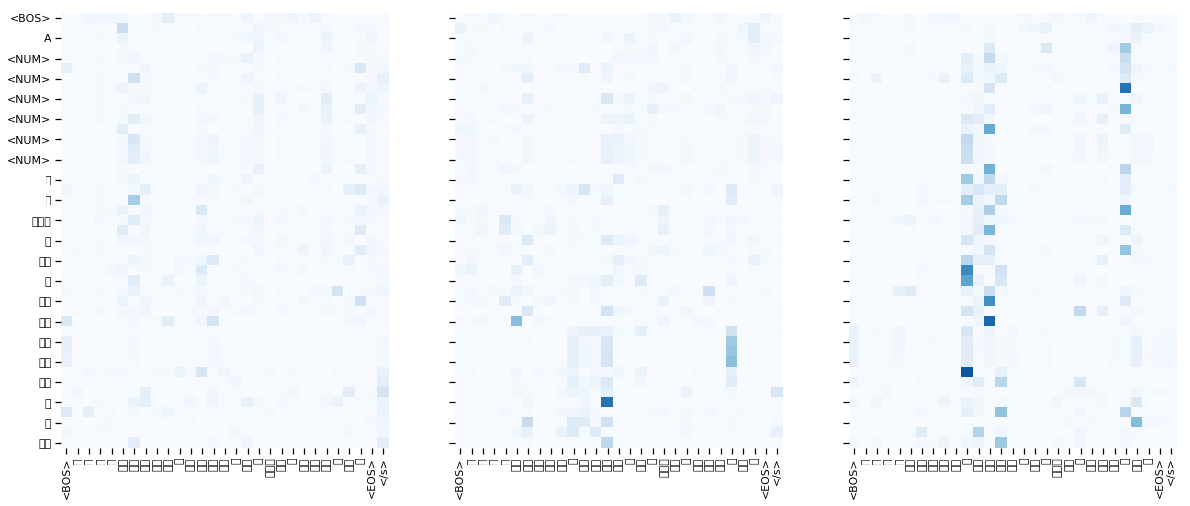

In [124]:
#Encoder Decoder Attention
# 1st layer
show_attentions(dec_enc_attns[0],
                pred_sent,
                src_sent,
                './Attention-Layer/dec-enc-attns/1st-dec-enc-attns.png',
                n_max=3)
#2nd Layer
show_attentions(dec_enc_attns[1],
                pred_sent,
                src_sent,
               './Attention-Layer/dec-enc-attns/2nd-dec-enc-attns.png',
               n_max=3)
#3rd Layer
show_attentions(dec_enc_attns[2], 
                pred_sent,
                src_sent,
               './Attention-Layer/dec-enc-attns/3rd-dec-enc-attns.png',
               n_max=3)

In [130]:
import matplotlib.font_manager as fm
import pandas as pd

fonts = fm.findSystemFonts()
print(fonts)

['/usr/share/fonts/open-sans/OpenSans-ExtraBold.ttf', '/usr/share/fonts/dejavu/DejaVuSerifCondensed-Bold.ttf', '/usr/share/fonts/google-crosextra-carlito/Carlito-Bold.ttf', '/usr/share/fonts/nhn-nanum/NanumGothicExtraBold.ttf', '/usr/share/fonts/dejavu/DejaVuSerifCondensed-BoldItalic.ttf', '/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf', '/usr/share/fonts/gnu-free/FreeSerif.ttf', '/usr/share/fonts/google-crosextra-caladea/Caladea-BoldItalic.ttf', '/usr/share/fonts/stix/STIX-Bold.otf', '/usr/share/fonts/opensymbol/opens___.ttf', '/usr/share/fonts/lohit-bengali/Lohit-Bengali.ttf', '/usr/share/fonts/open-sans/OpenSans-LightItalic.ttf', '/usr/share/fonts/dejavu/DejaVuSerifCondensed.ttf', '/usr/share/fonts/thai-scalable/Waree-Oblique.ttf', '/usr/share/fonts/open-sans/OpenSans-ExtraBoldItalic.ttf', '/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf', '/usr/share/fonts/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/lohit-marathi/Lohit-Marathi.ttf', '/usr/share/fonts/open-sans/Open

In [132]:
l = []
for f in fonts:
    font = fm.FontProperties(fname=f)
    l.append((f, font.get_name(), font.get_family()))
df = pd.DataFrame(l, columns=['path', 'name', 'family'])
df[df['path'].apply(lambda s: 'IPA' in s)]
print(df)

                                                  path                 name  \
0    /usr/share/fonts/open-sans/OpenSans-ExtraBold.ttf            Open Sans   
1    /usr/share/fonts/dejavu/DejaVuSerifCondensed-B...         DejaVu Serif   
2    /usr/share/fonts/google-crosextra-carlito/Carl...              Carlito   
3    /usr/share/fonts/nhn-nanum/NanumGothicExtraBol...          NanumGothic   
4    /usr/share/fonts/dejavu/DejaVuSerifCondensed-B...         DejaVu Serif   
5    /usr/share/fonts/dejavu/DejaVuSansCondensed-Bo...          DejaVu Sans   
6              /usr/share/fonts/gnu-free/FreeSerif.ttf            FreeSerif   
7    /usr/share/fonts/google-crosextra-caladea/Cala...              Caladea   
8                  /usr/share/fonts/stix/STIX-Bold.otf                 STIX   
9             /usr/share/fonts/opensymbol/opens___.ttf           OpenSymbol   
10    /usr/share/fonts/lohit-bengali/Lohit-Bengali.ttf        Lohit Bengali   
11   /usr/share/fonts/open-sans/OpenSans-LightItali.

In [133]:
plt.rcParams['font.family'] = 'IPAPGothic'

/home/develop/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


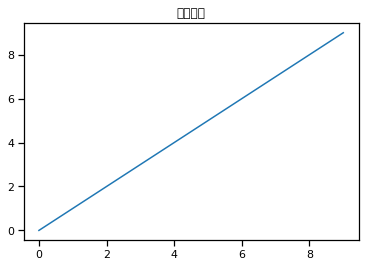

In [136]:
plt.plot(range(10),range(10))
plt.title('ああああ')
plt.show()